In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement, ClassicDP
from src.agents.bcd_grid import bcd, bcgd
from src.utils import Discretizer,generate_random_colors
from src.trainer import run_experiment
from src.plots import plot_gridworld
from src.models import PARAFAC

import tensorly as tl
from tensorly.decomposition import parafac

import torch
from tensorly.tenalg import khatri_rao

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import pickle


RANK ANALISYS FOR Q*

In [2]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[Tamaño,Tamaño],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

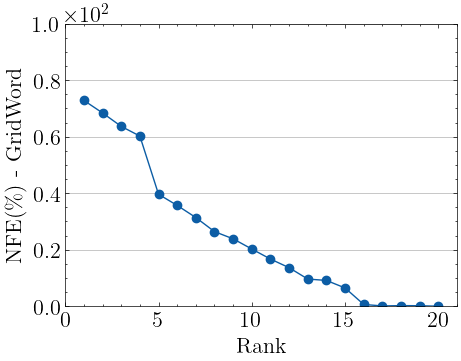

<Figure size 350x262.5 with 0 Axes>

In [3]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(Q_opt, None, 40)

POLICY EVALUATION WITH BCD

In [ ]:
k_list = [15,20,25,30]
scale = 1
num_iter = 500

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs, Q = bcd_inv.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

In [ ]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, num_iter-1)
        axes[0].set_ylim(0, 200)
        #axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, num_iter-1)
        #axes[1].set_ylim(0.1, 100)
        #axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCD-PE ",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PE")
    # Mostrar la figura
    plt.show()

POLICY EVALUATION WITH BCGD

In [ ]:
# GridWorld
k_list = [15, 20, 25, 30]
scale = 0.6
num_iter = 100000
alpha = 10e-3

fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA),alpha)

    fo_values,errors,convs, Q = bcd_grad.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

In [6]:
with open('results/exp_0000.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]

k_list = [15, 20, 25, 30]
num_iter = 100000

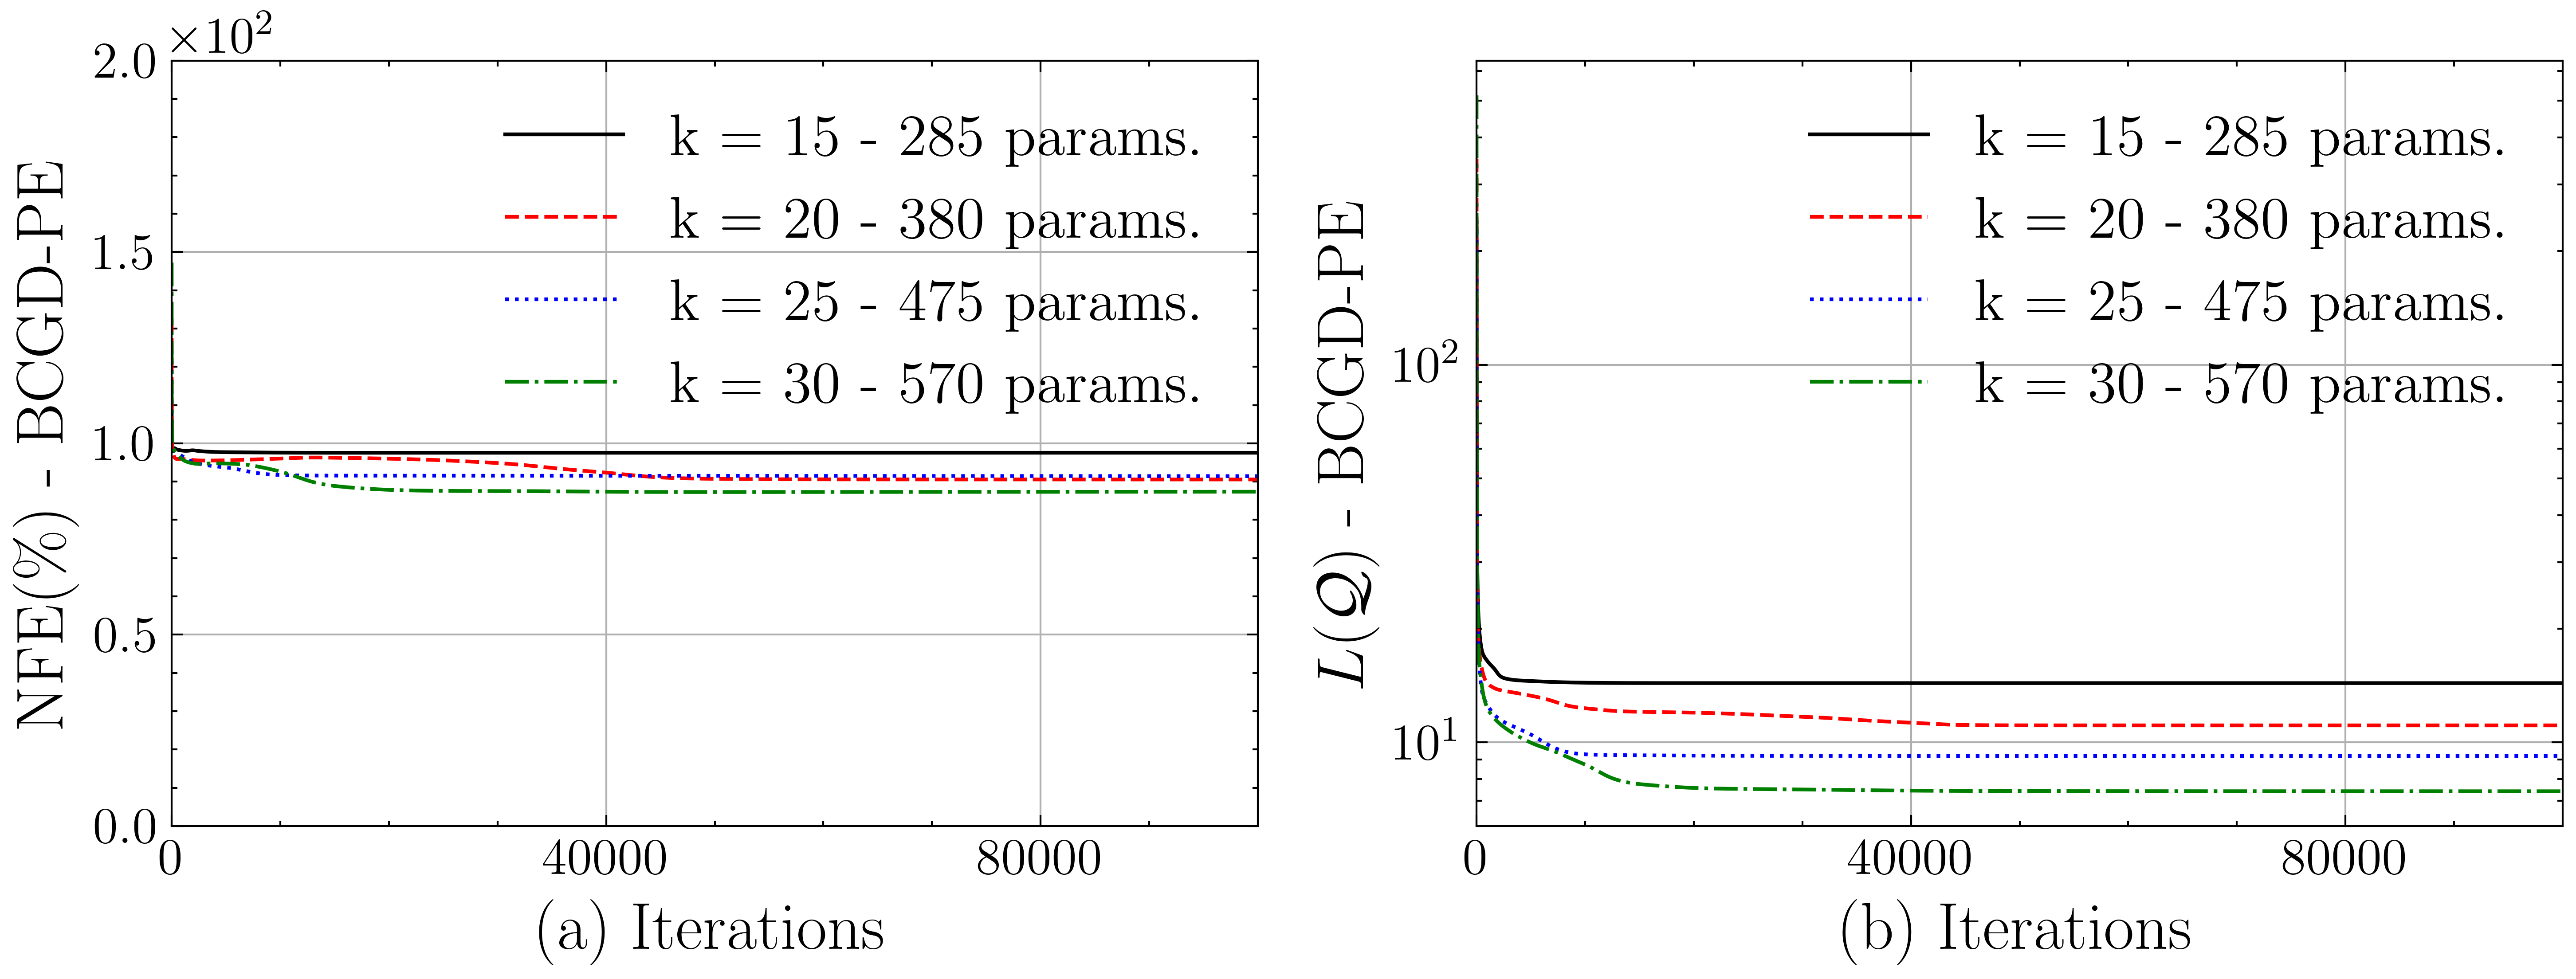

In [8]:

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, num_iter -1)
        axes[0].set_ylim(0, 200)
        axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, num_iter-1)
        #axes[1].set_ylim(0.1, 100)
        axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCGD-PE",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PE")
    # Mostrar la figura
    plt.show()

BCD - Policy Evaluation

In [6]:
k_list = [15, 20, 25, 30]
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [52]:
with open('policy-bcd.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

k_list = [10, 20, 30, 50]
policy_num_iter = 100

In [12]:
G_list = []
Policy_opt = Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA)
for i in range(10000):
    G = 0
    s, _ = ENV.reset()
    for h in range(ENV.H):
        s1, s2 = s
        dist = Policy_opt[h, s2, s1,:]
        a = [np.argmax(dist)]
        s, r, d, _, _ = ENV.step(a)
        G += r

        if d:
            break
    G_list.append(G)

opt_mean_return = np.mean(G_list)
print(opt_mean_return)

1.0


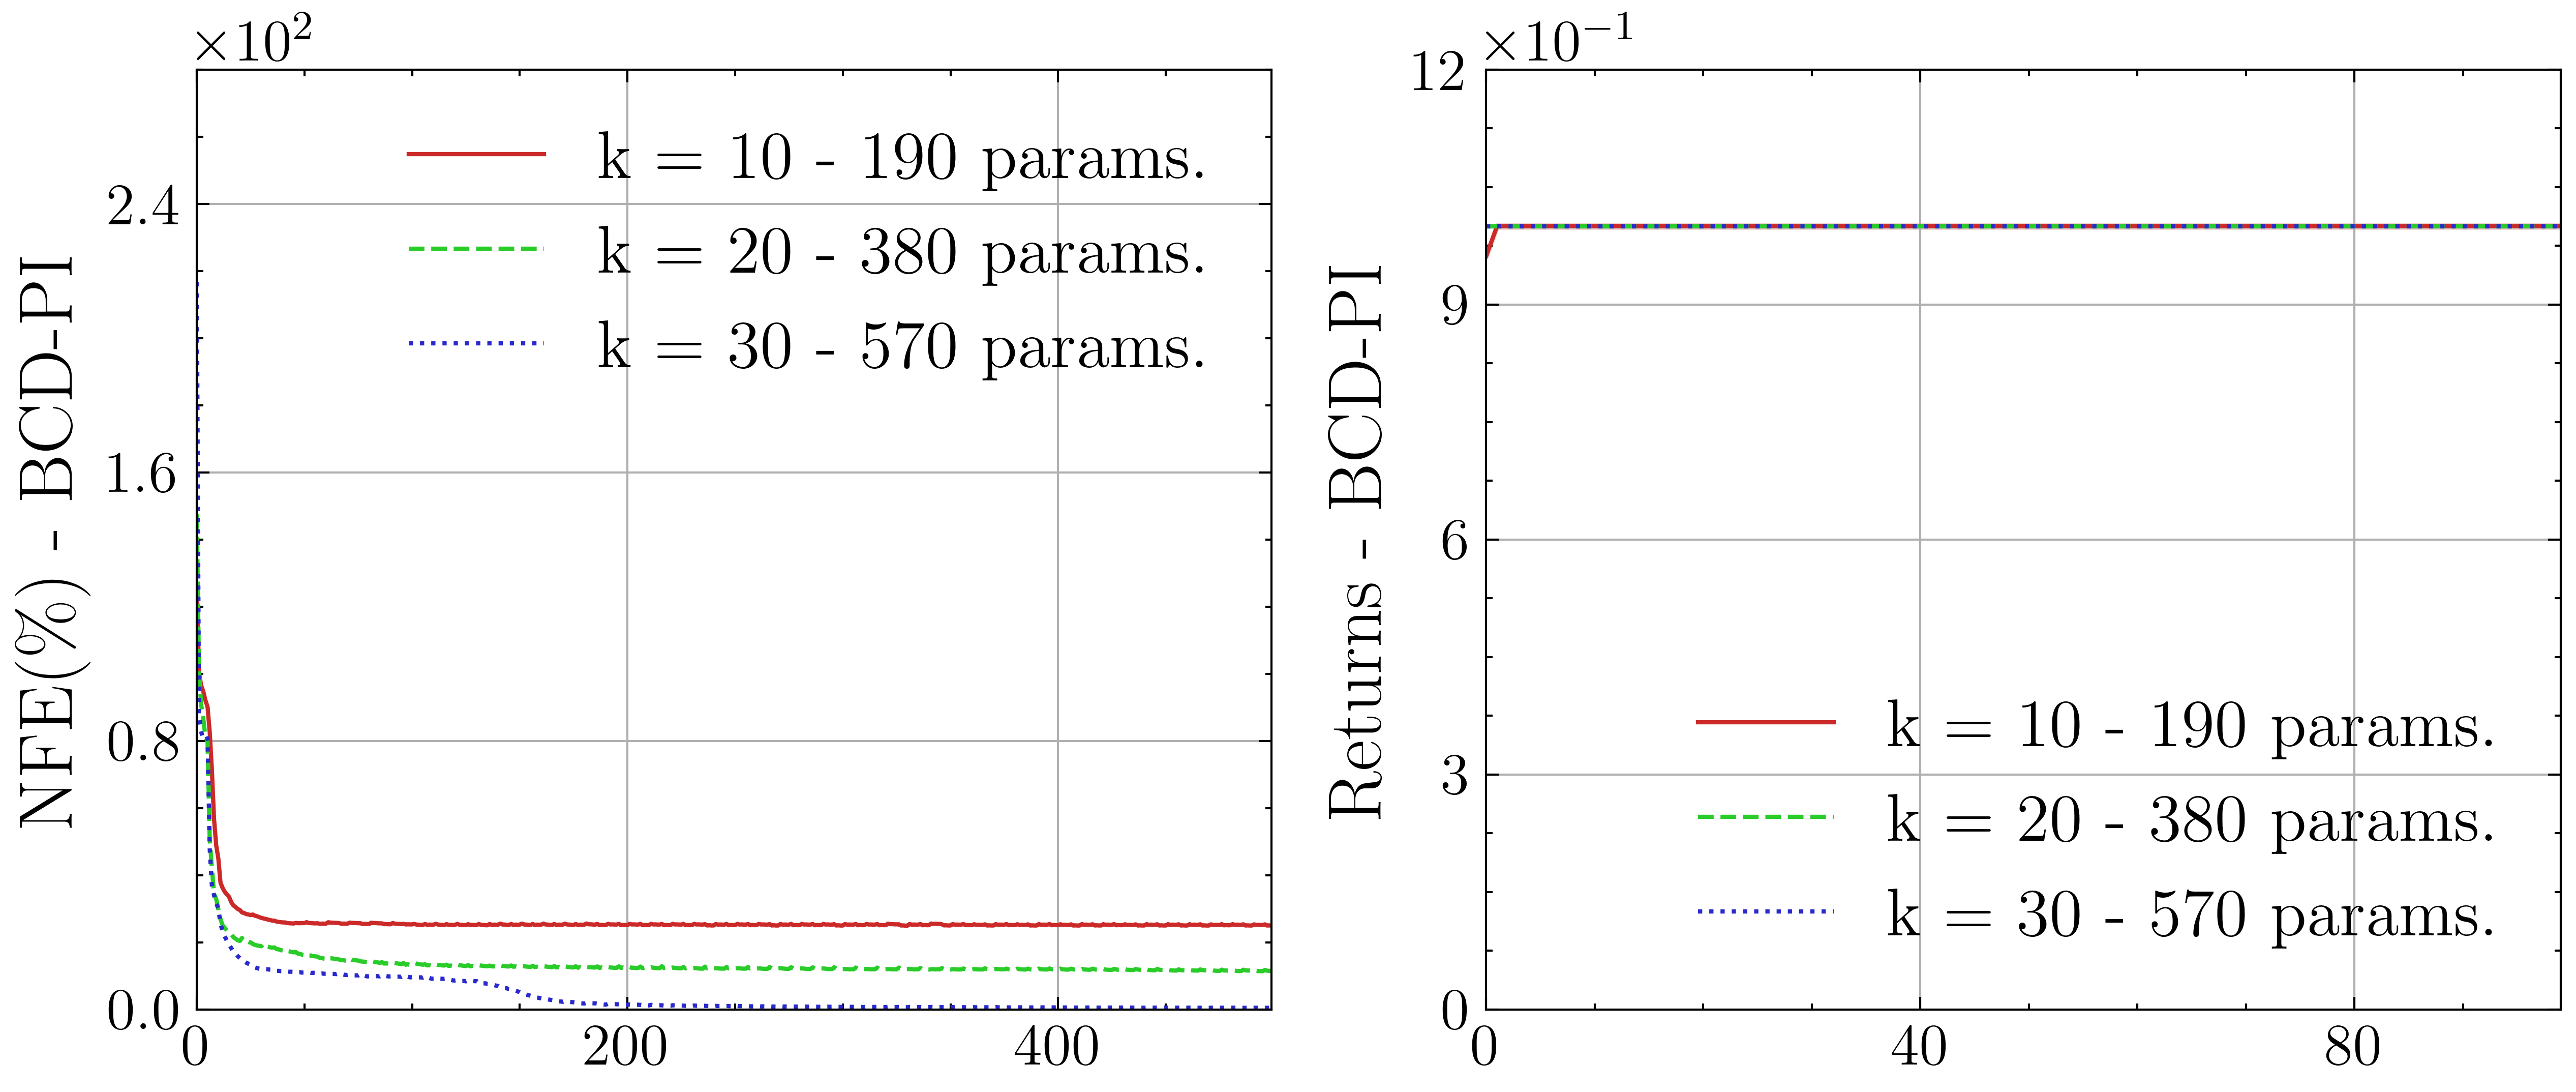

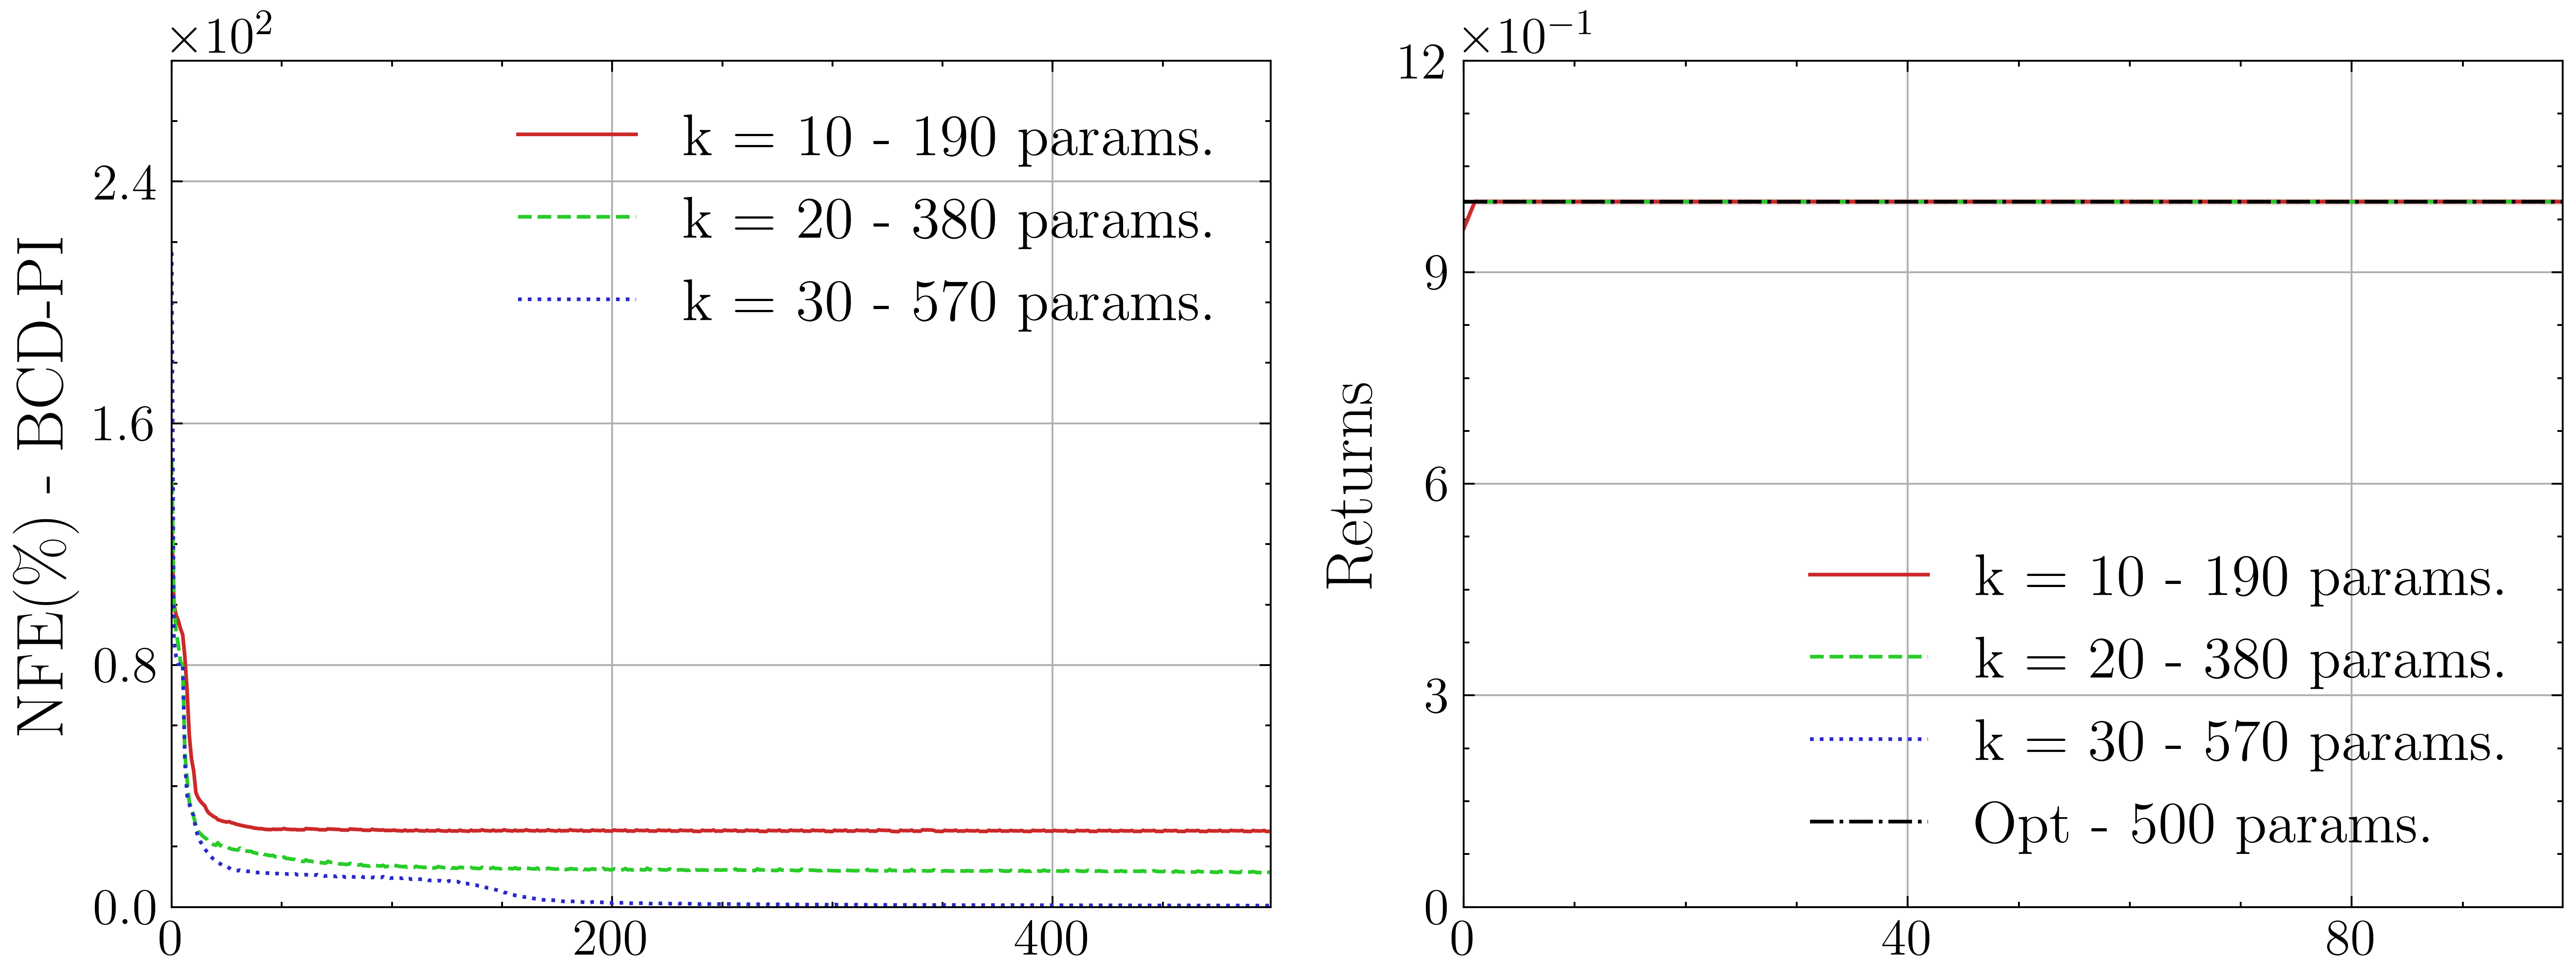

In [9]:
colors = generate_random_colors(len(k_list))
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, x_lim -1)
        axes[0].set_ylim(0, 280)
        #axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        #axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Returns - BCD-PI",fontsize=18)
        axes[1].legend(loc='lower right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter , color = 'black', label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(0, policy_num_iter - 1)
    axes[1].set_ylim(0, 1.2)
    #axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Returns ",fontsize=18)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PI_norm")
    # Mostrar la figura
    plt.show()

In [ ]:
k_list = [10, 20, 30, 50]
scale = 0.7
bcd_num_iter = 50
policy_num_iter = 2000
alpha = 10e-3

fo_list = []
errors_list = []
conv_list = []
returns_mean_list = []
returns_std_list = []

for k in k_list:
    Q = PARAFAC(
                np.concatenate(
                    [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
                ),
                k=k,
                scale= scale,
                nA=len(discretizer.bucket_actions),
            ).double()

    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA),alpha)
    fo_values,errors,convs,returns_mean,returns_std, Q = bcd_grad.bcgd_policy_improvement(policy_num_iter,bcd_num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)
    returns_mean_list.append(returns_mean)
    returns_std_list.append(returns_std)

In [16]:
with open('results/exp_1111.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

k_list = [15, 20, 25, 30]
scale = 0.5
bcd_num_iter = 50
policy_num_iter = 2000
alpha = 10e-3

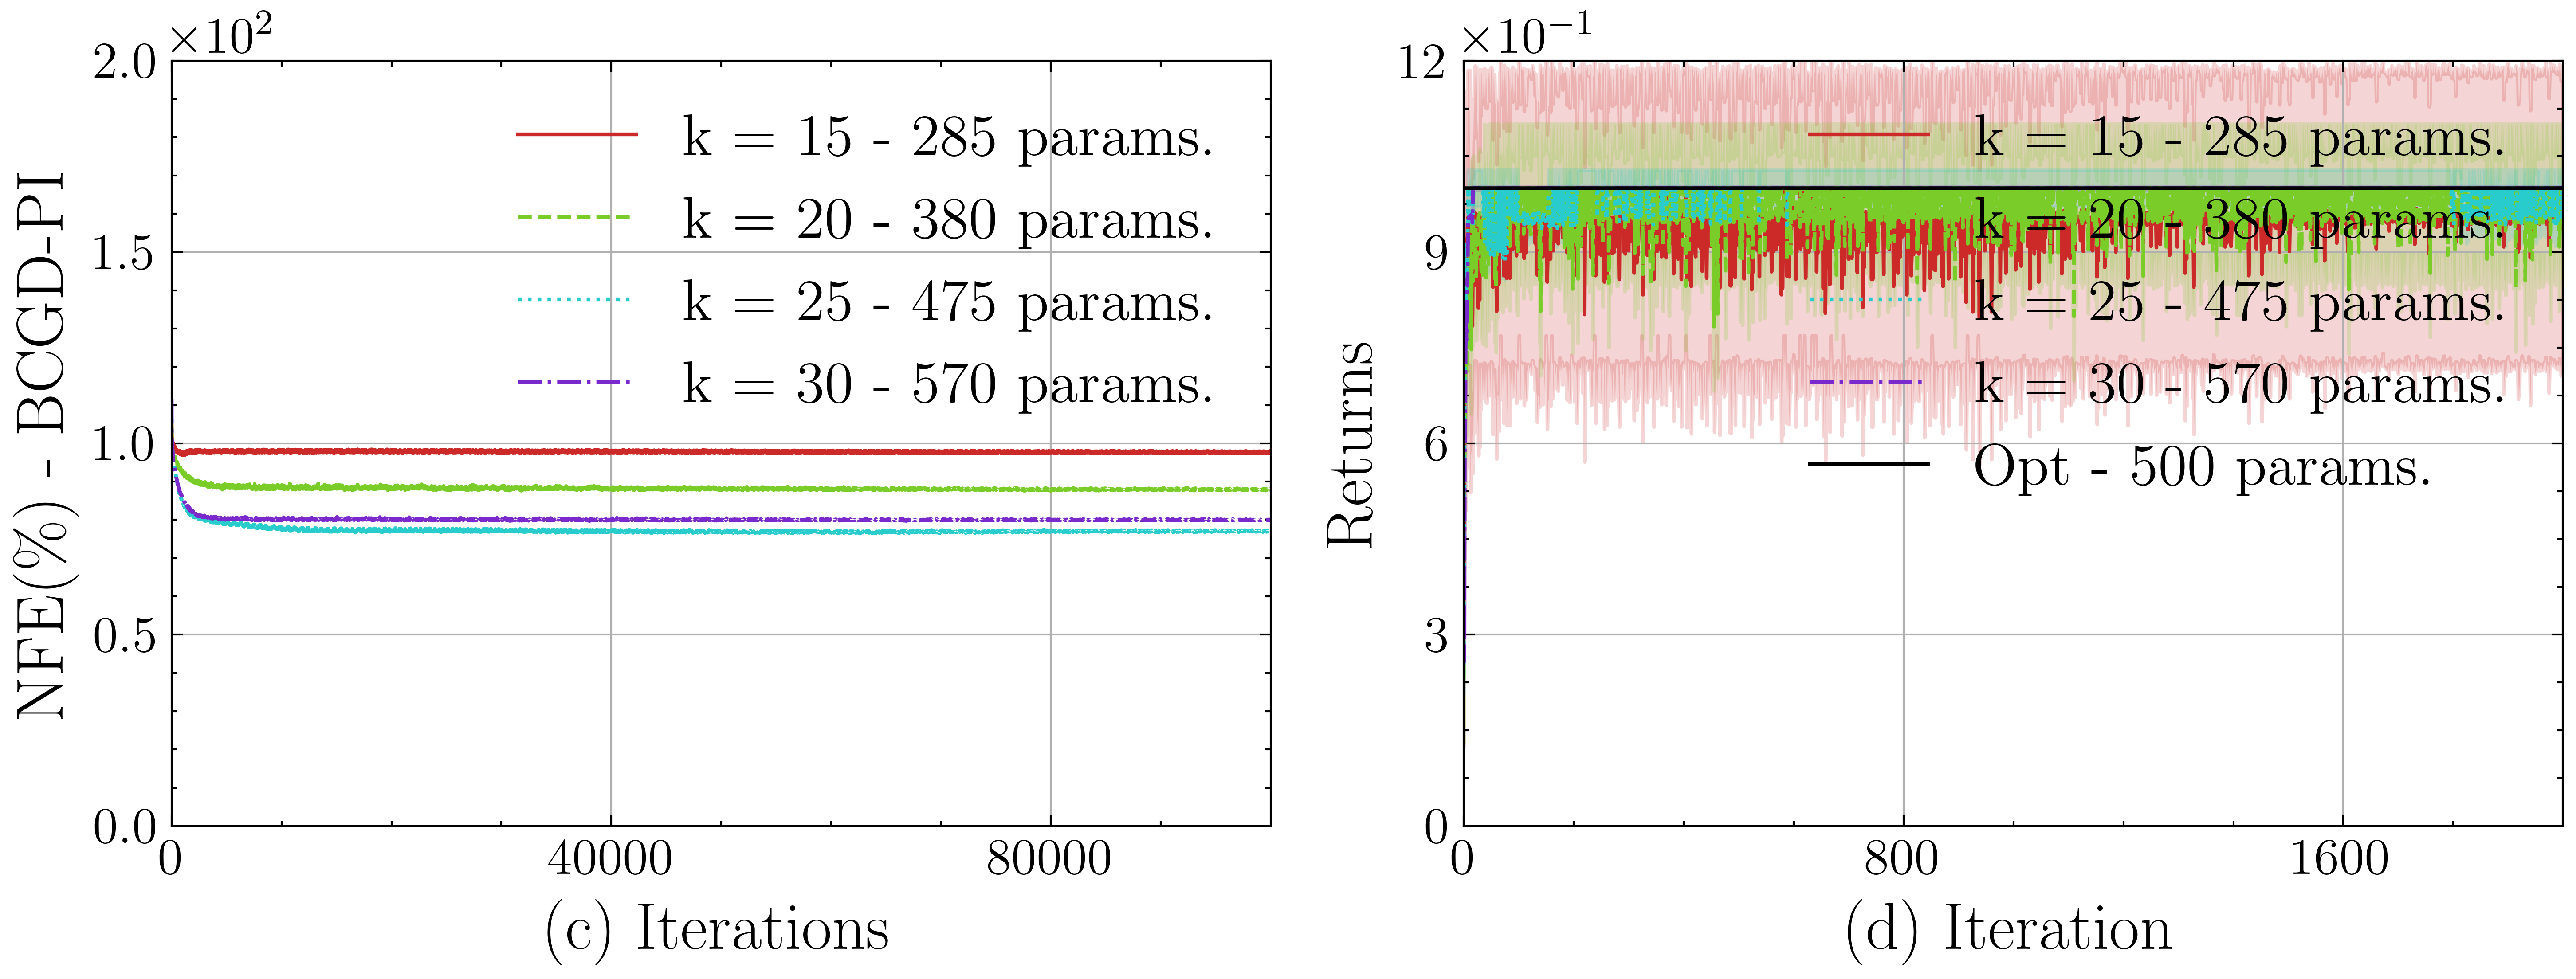

In [17]:
colors = generate_random_colors(len(k_list))
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(0, x_lim -1)
        axes[0].set_ylim(0, 200)
        axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Returns  - BCGD-PI",fontsize=18)
        axes[1].legend(loc='upper right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter , color = 'black', label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(0, policy_num_iter - 1)
    axes[1].set_ylim(0, 1.2)
    axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Returns ",fontsize=18)
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PI")
    # Mostrar la figura
    plt.show()
    

Plot de las matrices

In [6]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño)

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

k = 50
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

Q = PARAFAC(
        np.concatenate(
            [[ENV.H], DISCRETIZER.bucket_states, DISCRETIZER.bucket_actions]
        ),
        k=k,
        scale= scale,
        nA=len(DISCRETIZER.bucket_actions),
).double()

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)
clasic = ClassicDP(ENV.nS,ENV.nA,ENV.R,ENV.P)
bcd_inv = bcd(Q,Pi,DISCRETIZER,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

_ = bp_learner.run()
_ = clasic.run()
_,_,_,_,_, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)

bcd_inv = bcd(Q,Pi,DISCRETIZER,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

mat_classic = np.max(clasic.Q, axis=1).reshape(ENV.W,ENV.W)
mat_dp = np.max(bp_learner.Q[0,:], axis=1).reshape(ENV.W,ENV.W)
mat_pi = np.max(tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors])),axis=3)[0].reshape(ENV.W, ENV.W)

plot_gridworld(ENV.W, mat_classic, mat_dp, mat_pi)

<Figure size 9600x2400 with 0 Axes>

(0, 0)
(4, 4)
(0, 1)
(4, 3)
(0, 0)
(4, 4)


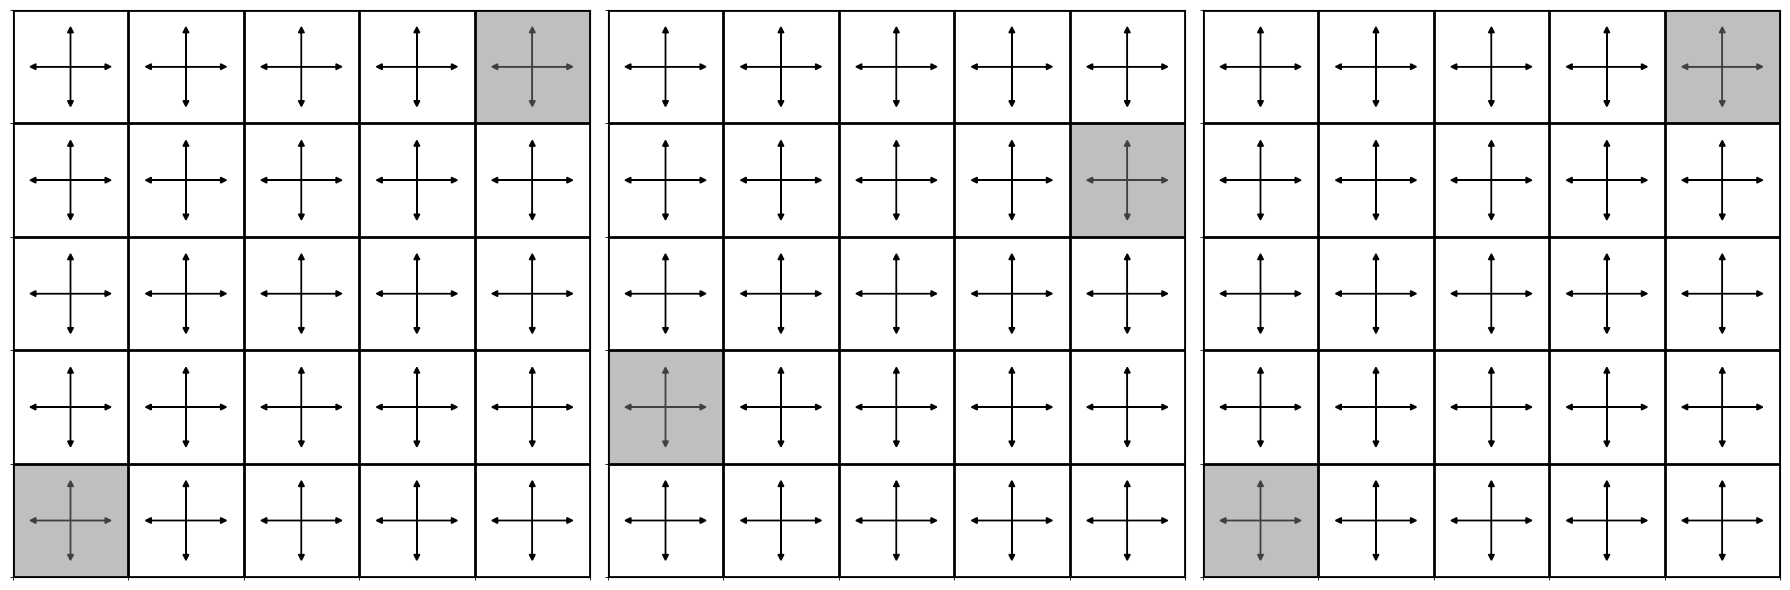

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def draw_grid_with_arrows(Q_1,Q_2,Q_3):
    # Configuración de la figura
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Coordenadas de las flechas para la cuadrícula 5x5
    grid_size = 5
    x = np.arange(grid_size)
    y = np.arange(grid_size)

    # Flechas en todas las direcciones
    directions = [(0, 0.3), (0, -0.3), (0.3, 0), (-0.3, 0)]  # (dx, dy) arriba, abajo, derecha, izquierda

    # Posiciones sombreadas en cada gráfico
    shaded_positions = [
        [(0, 0), (4, 4)],  # Primera imagen
        [(0, 1), (4, 3)],  # Segunda imagen
        [(0, 0), (4, 4)]   # Tercera imagen
    ]

    # Dibujar las 3 imágenes
    for idx, ax_idx in enumerate(ax):
        ax_idx.set_xlim(-0.5, grid_size - 0.5)
        ax_idx.set_ylim(-0.5, grid_size - 0.5)
        ax_idx.set_xticks(np.arange(-0.5, grid_size, 1), minor=True)
        ax_idx.set_yticks(np.arange(-0.5, grid_size, 1), minor=True)
        ax_idx.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax_idx.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # Dibujar flechas en cada celda
        for i in range(grid_size):
            for j in range(grid_size):
                for dx, dy in directions:
                    ax_idx.arrow(i, j, dx, dy, head_width=0.05, head_length=0.05, fc='black', ec='black')

        # Pintar las celdas sombreadas
        for pos in shaded_positions[idx]:
            print(pos)
            rect = plt.Rectangle((pos[0] - 0.5, pos[1] - 0.5), 1, 1, color='gray', alpha=0.5)
            ax_idx.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Llamada a la función
draw_grid_with_arrows(Q_opt,Q_opt,Q_opt)
